In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [5]:
import numpy as np 
import pandas as pd
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

from PIL import Image
import matplotlib.pyplot as plt

In [6]:
pic_path = '/MY DATA/db t2/marvel/data'

In [8]:
image=[]
labels=[]
for file in os.listdir(pic_path):
    if file=='black widow':
        for c in os.listdir(os.path.join(pic_path, file)):
                image.append(c)
                labels.append('black widow')
    if file=='ironman':
        for c in os.listdir(os.path.join(pic_path, file)):
                image.append(c)
                labels.append('ironman')
    if file=='captain america':
        for c in os.listdir(os.path.join(pic_path, file)):
                image.append(c)
                labels.append('captain america')
    if file=='spider-man':
        for c in os.listdir(os.path.join(pic_path, file)):
                image.append(c)
                labels.append('spider-man')
    if file=='thanos':
        for c in os.listdir(os.path.join(pic_path, file)):
                image.append(c)
                labels.append('thanos')
    if file=='doctor strange':
        for c in os.listdir(os.path.join(pic_path, file)):
                image.append(c)
                labels.append('doctor strange')
    if file=='loki':
        for c in os.listdir(os.path.join(pic_path, file)):
                image.append(c)
                labels.append('loki')
    if file=='hulk':
        for c in os.listdir(os.path.join(pic_path, file)):
                image.append(c)
                labels.append('hulk')
data = {'Images':image, 'labels':labels} 
data = pd.DataFrame(data) 
data

,Images,labels
0,pic_001.jpg,black widow
1,pic_002.jpg,black widow
2,pic_003.jpg,black widow
3,pic_004.jpg,black widow
4,pic_005.jpg,black widow
...,...,...
2746,pic_396.jpg,thanos
2747,pic_397.jpg,thanos
2748,pic_398.jpg,thanos
2749,pic_399.jpg,thanos


In [25]:
from sklearn.preprocessing import LabelEncoder
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])
data.tail()

,Images,labels,encoded_labels
2746,pic_396.jpg,thanos,7
2747,pic_397.jpg,thanos,7
2748,pic_398.jpg,thanos,7
2749,pic_399.jpg,thanos,7
2750,pic_400.jpg,thanos,7


In [1]:
batch_size = 128

In [27]:
validation_split=.25
random_seed= 42
dataset_size = len(data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True
if shuffle_dataset :
    np.random.seed(random_seed) #makes sure that we get the same values everytime 
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

In [28]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [29]:
class Marvel_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = Image.open(img_name)
        image = image.resize((300,300))
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [30]:
dataset = Marvel_Dataset(data,pic_path,transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,sampler=valid_sampler)

In [31]:
def img_display(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

In [32]:
# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images,labels = images,labels
hero_types = {0: 'black widow', 1: 'captain america', 2: 'doctor strange', 3: 'hulk', 4: 'ironman', 5: 'loki', 6: 'spider-man', 7: 'thanos'}

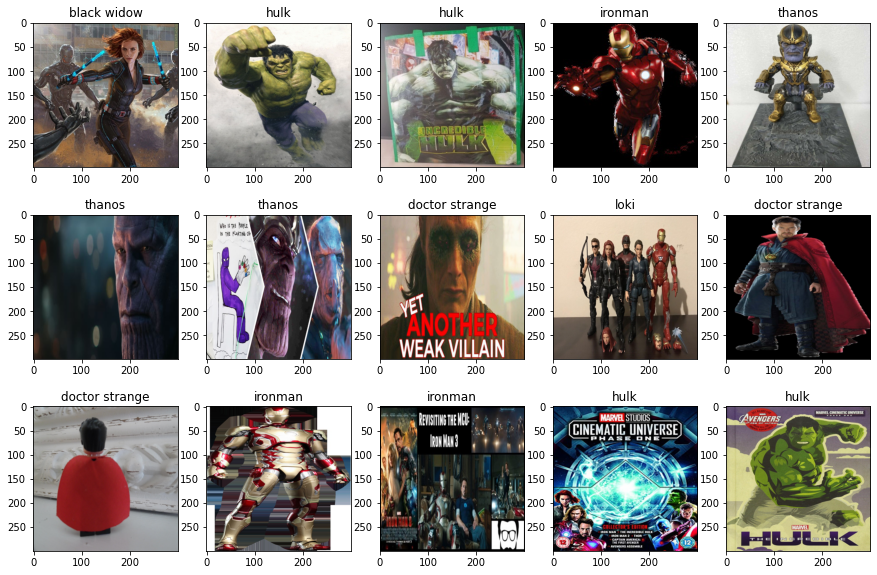

In [33]:
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(img_display(image)) # add image
        ax.set(title = f"{hero_types[label.item()]}") # add label

In [34]:
 class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3,16,kernel_size=3,stride=2,padding=1)
        self.conv2 = nn.Conv2d(16, 32,kernel_size=3,stride=2, padding=1)
        self.conv3 = nn.Conv2d(32, 64,kernel_size=3,stride=2, padding=1)
        self.conv4 = nn.Conv2d(64, 64,kernel_size=3,stride=2, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.4)
        self.batchnorm1 = nn.BatchNorm2d(16)
        self.batchnorm2 = nn.BatchNorm2d(32)
        self.batchnorm3 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64*5*5,512 )
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 8)
        
    def forward(self, x):
        x = self.batchnorm1(F.relu(self.conv1(x)))
        x = self.batchnorm2(F.relu(self.conv2(x)))
        x = self.dropout(self.batchnorm2(self.pool(x)))
        x = self.batchnorm3(self.pool(F.relu(self.conv3(x))))
        x = self.dropout(self.conv4(x))
        x = x.view(-1, 64*5*5) # Flatten layer
        x = self.dropout(self.fc1(x))
        x = self.dropout(self.fc2(x))
        x = F.log_softmax(self.fc3(x),dim = 1)
        return x

In [35]:
model = Net().to(device)  # On GPU
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.4, inplace=False)
  (batchnorm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1600, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=8, bias=True)
)


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [37]:
def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

In [44]:
n_epochs = 36
print_every = 10
valid_loss_min = np.inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_loader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_loader):
        data_, target_ = data_.to(device), target_.to(device)# on GPU
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(data_)
        loss = criterion(outputs, target_.long())
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain loss: {np.mean(train_loss):.4f}, train acc: {(100 * correct / total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        model.eval()
        for data_t, target_t in (validation_loader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = model(data_t)
            loss_t = criterion(outputs_t, target_t.long())
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t / total_t)
        val_loss.append(batch_loss/len(validation_loader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t / total_t):.4f}\n')
        # Saving the best weight 
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(model.state_dict(), 'model_classification_.pt')
            print('Detected network improvement, saving current model')
    model.train()

Epoch 1

Epoch [1/36], Step [0/17], Loss: 1.8845

train loss: 1.8423, train acc: 35.3198
validation loss: 1.9037, validation acc: 25.6186

Detected network improvement, saving current model
Epoch 2

Epoch [2/36], Step [0/17], Loss: 1.7169

train loss: 1.7990, train acc: 36.8217
validation loss: 1.9107, validation acc: 26.2009

Epoch 3

Epoch [3/36], Step [0/17], Loss: 1.6824

train loss: 1.7737, train acc: 37.8391
validation loss: 1.9185, validation acc: 25.0364

Epoch 4

Epoch [4/36], Step [0/17], Loss: 1.7987

train loss: 1.7533, train acc: 39.2926
validation loss: 1.9279, validation acc: 26.0553

Epoch 5

Epoch [5/36], Step [0/17], Loss: 1.6019

train loss: 1.7380, train acc: 39.4864
validation loss: 1.9314, validation acc: 26.2009

Epoch 6

Epoch [6/36], Step [0/17], Loss: 1.7337

train loss: 1.7222, train acc: 40.7946
validation loss: 1.9407, validation acc: 25.6186

Epoch 7

Epoch [7/36], Step [0/17], Loss: 1.5322

train loss: 1.7075, train acc: 41.5698
validation loss: 1.9469, v

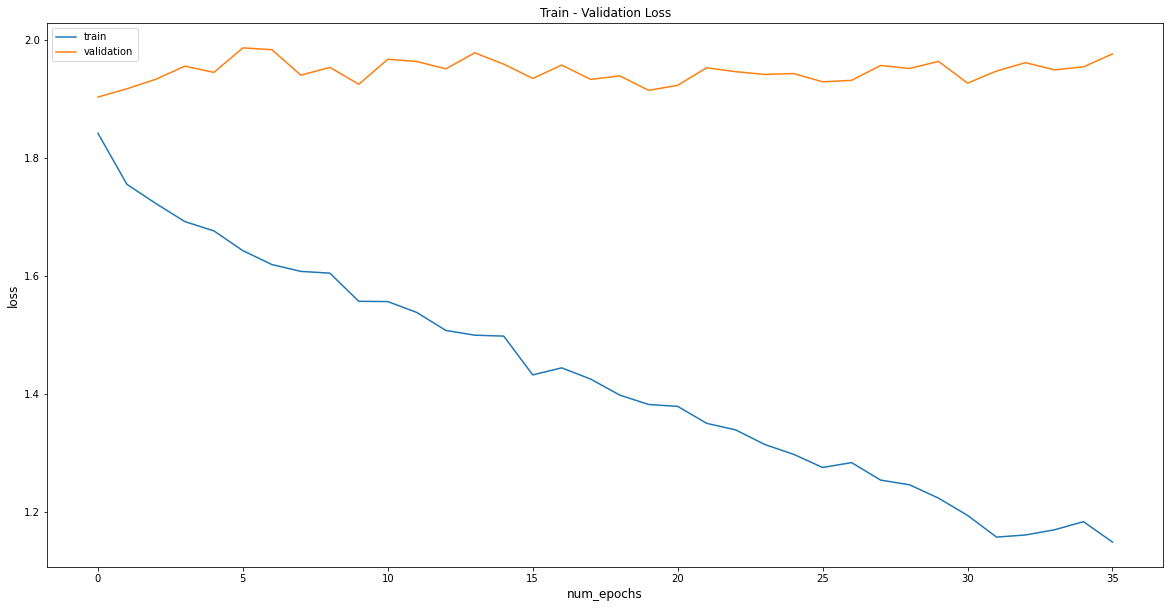

In [47]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Loss")
plt.plot( train_loss, label='train')
plt.plot( val_loss, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.legend(loc='best')

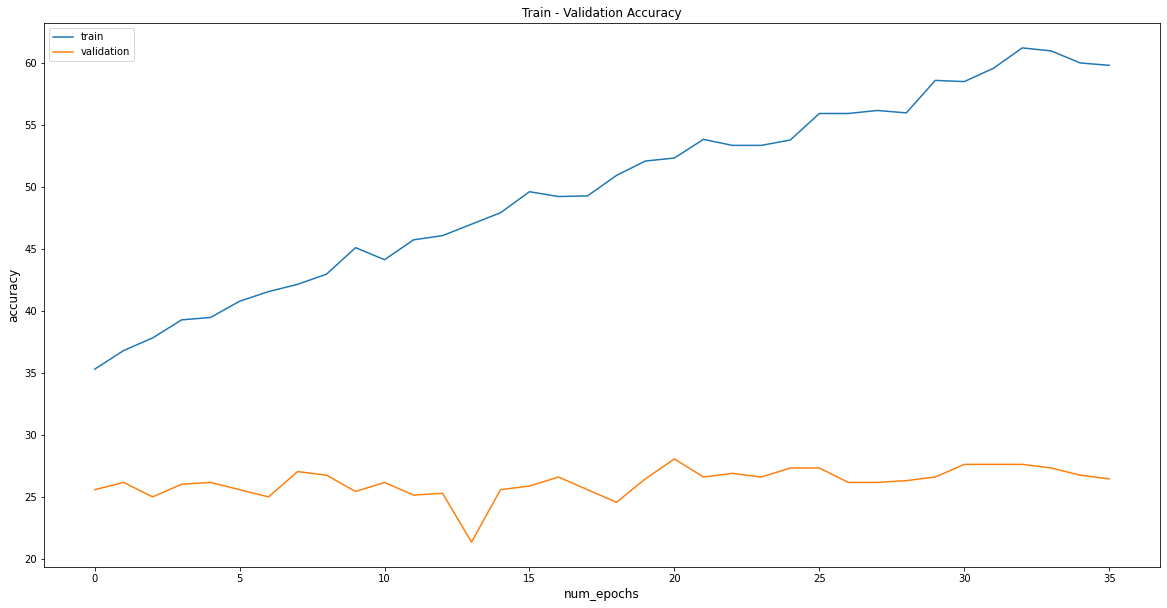

In [48]:
fig = plt.figure(figsize=(20,10))
plt.title("Train - Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

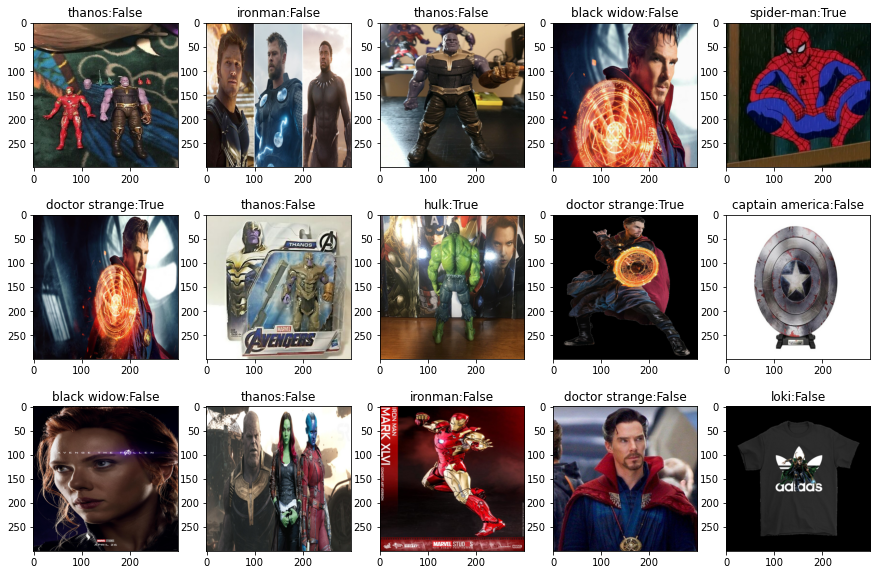

In [52]:
dataiter = iter(validation_loader)
images, labels = dataiter.next()
marv_types = {0: 'black widow', 1: 'captain america', 2: 'doctor strange', 3: 'hulk', 4: 'ironman', 5: 'loki',
                 6: 'spider-man', 7: 'thanos'}

# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
with torch.no_grad():
    model.eval()
    for ax, image, label in zip(axis.flat,images, labels):
        ax.imshow(img_display(image)) # add image
        image_tensor = image.unsqueeze_(0)
        image_tensor=image_tensor.to(device)
        output_ = model(image_tensor)
        output_ = output_.argmax()
        k = output_.item()==label.item()
        ax.set_title(str(marv_types[label.item()])+":" +str(k)) 